In [1]:
import math
import torch
from torch import Tensor
from torch import nn
import torch.nn.functional as F
from typing import Optional, List
import torchvision.transforms as transforms
from PIL import Image
from torchvision.models import resnet50,ResNet50_Weights
from torch import Tensor
from matplotlib import cm
from torchvision.transforms.functional import to_pil_image
import os  

In [2]:
# 记得在文件开头导入相应的模型和权重  
from torchvision.models import (  
    resnet50, resnet101, resnet18, resnet34,  
    densenet121, densenet169, densenet201,  
    vgg16, vgg19,  
    efficientnet_b0, efficientnet_b1, efficientnet_b2,  
    mobilenet_v2, mobilenet_v3_small, mobilenet_v3_large,  
    shufflenet_v2_x0_5, shufflenet_v2_x1_0  
)  
from torchvision.models import (  
    ResNet50_Weights, ResNet101_Weights, ResNet18_Weights, ResNet34_Weights,  
    DenseNet121_Weights, DenseNet169_Weights, DenseNet201_Weights,  
    VGG16_Weights, VGG19_Weights,  
    EfficientNet_B0_Weights, EfficientNet_B1_Weights, EfficientNet_B2_Weights,  
    MobileNet_V2_Weights, MobileNet_V3_Small_Weights, MobileNet_V3_Large_Weights,  
    ShuffleNet_V2_X0_5_Weights, ShuffleNet_V2_X1_0_Weights  
) 
def process_image_withhooks(img_path, model_weights=ResNet50_Weights.DEFAULT):  
    """  
    处理图片并计算特征和梯度的加权值donations_values  

    Args:  
        img_path (str): 输入图片的路径  
        model_weights: 模型的预训练权重，默认为ResNet50的默认权重  

    Returns:  
        tensor: shape (num_classes,) 的 tensor，表示各个类别的donations_values  
    """  
    # 定义预处理步骤  
    test_transform = transforms.Compose([  
        transforms.Resize(512),  
        transforms.ToTensor(),  
        transforms.Normalize(  
            mean=[0.485, 0.456, 0.406],  
            std=[0.229, 0.224, 0.225]  
        )  
    ])  

    # 获取设备  
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')  

    # 初始化模型  
    # model = resnet50(weights=model_weights).eval().to(device)  
    model = vgg19(weights=VGG19_Weights.DEFAULT).eval().to(device) 

    # print(f"try to open image, path：{img_path}")  
    if not img_path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):  
        print(f"跳过非图片文件：{img_path}")  
        return None  

    # 加载图片  
    img_pil = Image.open(img_path)  

    # 预处理图片  
    input_tensor = test_transform(img_pil).unsqueeze(0).to(device)  

    # 定义前向hook  
    def forward_hook(module, inp, outp):  
        feature_map.append(outp)  

    # 定义反向hook  
    def backward_hook(module, inp, outp):  
        grad.append(outp)  

    # 初始化容器  
    feature_map = []  
    grad = []  
    
    def select_hook_layer(model, model_type):  
        if model_type.startswith('resnet'):  
            return model.layer4[-1]  
        elif model_type.startswith('densenet'):  
            return model.features[-1]  
        elif model_type.startswith('vgg'):  
            return model.features[-1]  
        elif model_type.startswith('efficientnet'):  
            return model.features[-1]  
        elif model_type.startswith('mobilenet'):  
            return model.features[-1]  
        elif model_type.startswith('shufflenet'):  
            return model.conv5  
        else:  
            raise ValueError(f"Unsupported model type: {model_type}")  
    
    # 使用示例  
    hook_layer = select_hook_layer(model, type(model).__name__.lower()) 
    hook_handle = hook_layer.register_forward_hook(forward_hook)  
    grad_hook_handle = hook_layer.register_full_backward_hook(backward_hook)  

    try:  
        # 前向传播  
      
        out = model(input_tensor)  
        cls_idx = torch.argmax(out).item()  
        # 计算预测类别分数  
        score = out[:, cls_idx].sum()  

        # 反向传播  
        model.zero_grad()  
        score.backward(retain_graph=False)  # 减少内存占用  

        # 获取特征和梯度  
        weights = grad[0][0].squeeze(0).mean(dim=(1, 2))  #GAP(a)
        mean_values= feature_map[0].squeeze(0).mean(dim=(1, 2))  

        # 计算加权后的值  
        # donations_values = mean_values * weights  
        donations_values = mean_values * weights

        return donations_values.detach().cpu()  

    except Exception as e:  
        print(f"处理过程中出现错误：{e}")  
        return None  

    finally:  
        # 删除hook并清理数据  
        hook_handle.remove()  
        grad_hook_handle.remove()  
        feature_map.clear()  
        grad.clear()  

        # 删除GPU上的张量并释放内存  
        if input_tensor.is_cuda:  
            del input_tensor  
            torch.cuda.empty_cache()  

        if 'out' in locals():  
            del out  
        if 'score' in locals():  
            del score

In [3]:
img_path="dataset/波斯猫/1.jpg"
donations_values=process_image_withhooks(img_path, model_weights=ResNet50_Weights.DEFAULT)
print(donations_values)
donations_values.size()

tensor([-1.3518e-05, -1.4451e-05,  2.6643e-04, -2.3498e-06, -2.7729e-05,
         1.3818e-03, -7.6589e-05, -1.5676e-04, -2.7575e-04, -1.4942e-04,
        -6.3381e-06, -1.5541e-06, -1.1554e-04, -3.9745e-05,  4.7729e-04,
        -1.0200e-05, -1.5937e-04, -4.9946e-05,  1.1833e-03,  2.4347e-04,
         4.4077e-05, -1.4593e-05, -1.3164e-05, -4.2198e-06,  4.8153e-06,
        -2.2813e-04,  3.8473e-05, -9.7510e-05, -1.2622e-05, -2.8325e-05,
        -1.2836e-04,  3.5895e-05,  2.1265e-04,  1.2712e-04, -1.4647e-05,
        -3.6519e-05, -2.9922e-06,  4.3406e-04, -7.7390e-05, -7.4380e-06,
         1.2415e-03, -9.9441e-05, -1.3307e-07,  2.3487e-05,  2.2842e-05,
         1.1986e-05,  3.5429e-05, -7.5926e-05, -1.8982e-05,  1.0230e-03,
        -1.1319e-05, -5.6952e-06, -7.4092e-05, -5.2184e-07,  9.5397e-06,
        -1.4770e-06,  6.0517e-05, -2.3366e-04, -4.8461e-05, -3.1214e-05,
         2.4564e-05,  4.2064e-06, -3.1076e-06, -1.4410e-04, -6.8173e-05,
         1.6731e-05, -4.3394e-05, -2.0580e-05, -4.9

torch.Size([512])

In [4]:
import numpy as np  

# 配置PyTorch的内存分配参数，减少内存碎片  
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'  

def process_batch_images_with_dict(class_path, batch_size=5, device=None):  
    """  
    批量处理一个类别下的所有图片，并返回每张图片的donations_values列表  

    Args:  
        class_path (str): 类别图片的路径  
        batch_size (int): 批次大小，缺省值为8  
        device (str or torch.device, optional): 设备类型（"cpu" 或 "cuda"），缺省值为 None，会自动检测  

    Returns:  
        dict: 键是img_path，值是对应的donations_value  
    """  
    if device is None:  
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
    print("\nusing device:" + str(device))  
    print("analyse class:" + str(class_path))  
    donations_dict = {}  # 使用字典存储结果  

    # 获取图片文件路径列表  
    img_paths = [os.path.join(class_path, f) for f in os.listdir(class_path)  
                 if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]  

    # 计算总批次数  
    total_batches = len(img_paths) // batch_size  
    if len(img_paths) % batch_size != 0:  
        total_batches += 1  

    succeed_img = 0  
    # 分批次处理图片  
    for batch_idx in range(total_batches):  
        start = batch_idx * batch_size  
        end = min((batch_idx + 1) * batch_size, len(img_paths))  
        batch_paths = img_paths[start:end]  

        batch_features = []  

        # 逐张处理图片以减少内存占用  
        for img_path in batch_paths:  
            try:  
                # 使用process_image_withhooks处理图片  
                donations_value = process_image_withhooks(img_path)  

                if donations_value is not None:  
                    #添加到批次结果  
                    # print("succeed to process image:" + img_path)  
                    succeed_img += 1  
                    batch_features.append((img_path, donations_value))  

            except Exception as e:  
                print(f"处理 {img_path} 时发生错误：{str(e)}")  
                continue  

        # 如果批次中没有有效的特征，跳过  
        if not batch_features:  
            continue  

        # 将批次的特征拼接到结果字典  
        for img_path, donations_value in batch_features:  
            donations_dict[img_path] = donations_value  

        # 释放当前批次的内存  
        batch_features.clear()  

    print(f"all_imgs : {succeed_img}")  
    return donations_dict  

In [5]:
# class_path1="dataset/n02105505/" #匈牙利牧羊犬
# class_path2="dataset/n02101006/" #戈登雪达犬
# # class_path3="dataset/n01910747/" #水母
# donations_values_list1 = process_batch_images(class_path1)
# donations_values_list2 = process_batch_images(class_path2)
# donations_values_list3 = process_batch_images(class_path3)


In [6]:
# class_path1="dataset/n01532829/" #家朱雀
# class_path2="dataset/n01558993/" #蓝鹀
class_path1="dataset/n02105505/" #匈牙利牧羊犬
class_path2="dataset/n02108089/" #戈登雪达犬
donations_values_list1 = process_batch_images_with_dict(class_path1)  
donations_values_list2 = process_batch_images_with_dict(class_path2)



using device:cuda
analyse class:dataset/n02105505/
all_imgs : 100

using device:cuda
analyse class:dataset/n02108089/
all_imgs : 100


In [13]:
from sklearn.metrics.pairwise import cosine_similarity  
import numpy as np 
def analyze_intra_class_similarity_with_dict(donations_dict, top_n=20):  
    """  
    分析同一类别中所有图片两两之间的余弦相似度，并返回相似度最大的和最小的样本对的图片路径及相似度值。  

    Args:  
        donations_dict (dict): 键为img_path，值为对应的donations_value的字典。  
        top_n (int, optional): 指定要返回的最大和最小的样本对数。默认为20。  

    Returns:  
        dict: 一个字典，包含：  
            - 'max_similarity': 相似度最大的top_n组样本对的img_path和相似度值。  
            - 'min_similarity': 相似度最小的top_n组样本对的img_path和相似度值。  

    Raises:  
        ValueError: 如果donations_dict中包含的样本数量少于2。  
    """  
    if len(donations_dict) < 2:  
        raise ValueError("需要至少两个样本来计算相似度。")  

    # 将字典转换为img_path列表和对应的donations_values数组  
    img_paths = list(donations_dict.keys())  
    donations_array = np.stack([donations_dict[img_path].numpy() for img_path in img_paths])  

    # 计算余弦相似度矩阵  
    similarity_matrix = cosine_similarity(donations_array)  

    # 提取上三角部分，忽略对角线  
    upper_triangle = np.triu(similarity_matrix, k=1)  

    # 展平上三角部分为1D数组，并获取索引  
    upper_triangle_flat = upper_triangle.flatten()  
    indices = np.triu_indices(len(upper_triangle), k=1)  

    # 创建一个数组，保存每个相似度值及其对应的两个样本索引  
    similarity_with_indices = list(zip(upper_triangle_flat, indices[0], indices[1]))  

    # 将相似度值从大到小排序  
    similarity_with_indices.sort(key=lambda x: -x[0])  

    # 提取最大的top_n组  
    max_similarity = []  
    for i in range(top_n):  
        if i >= len(similarity_with_indices):  
            break  
        similarity, idx1, idx2 = similarity_with_indices[i]  
        # 将索引转换为img_path  
        img_path1 = img_paths[idx1]  
        img_path2 = img_paths[idx2]  
        max_similarity.append({  
            'img_path1': img_path1,  
            'img_path2': img_path2,  
            'similarity': similarity  
        })  

    # 将相似度值从小到大排序  
    similarity_with_indices.sort(key=lambda x: x[0])  

    # 提取最小的top_n组  
    min_similarity = []  
    for i in range(top_n):  
        if i >= len(similarity_with_indices):  
            break  
        similarity, idx1, idx2 = similarity_with_indices[i]  
        img_path1 = img_paths[idx1]  
        img_path2 = img_paths[idx2]  
        min_similarity.append({  
            'img_path1': img_path1,  
            'img_path2': img_path2,  
            'similarity': similarity  
        })  

    return {  
        'max_similarity': max_similarity,  
        'min_similarity': min_similarity  
   }

In [14]:
import os  
import matplotlib.pyplot as plt  

def extract_number_from_path(img_path):  
    """  
    从图片路径中提取末尾的数字部分。  
    
    Args:  
        img_path (str): 图片的全路径。  
    
    Returns:  
        str: 提取的数字部分。  
    """  
    filename = os.path.basename(img_path)  
    # 假设文件名格式为'n01532829_24.jpg'，提取'24'  
    number_part = os.path.splitext(filename)[0].split('_')[-1]  
    return number_part  

def visualize_similarity_results_with_dict(result, top_n=20):  
    # 初始化matplotlib的参数  
    plt.rcParams['figure.dpi'] = 120  
    plt.rcParams['font.size'] = 10  

    # 创建一个figure和两个子图  
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))  

    # 处理最大相似度的Top-N  
    max_similarity = result['max_similarity'][:top_n]  
    max_sim_values = [pair['similarity'] for pair in max_similarity]  
    max_img_paths = [(pair['img_path1'], pair['img_path2']) for pair in max_similarity]  
    max_img1_nums = [extract_number_from_path(img_path[0]) for img_path in max_img_paths]  
    max_img2_nums = [extract_number_from_path(img_path[1]) for img_path in max_img_paths]  
    max_labels = [f"({num1}, {num2})" for num1, num2 in zip(max_img1_nums, max_img2_nums)]  

    # 最大相似度折线图  
    ax1.plot(max_labels, max_sim_values, marker='o', linestyle='-', color='b')  
    ax1.set_title('Top-{} Similarity Pairs'.format(top_n))  
    ax1.set_xlabel('Image Pairs (Number)')  
    ax1.set_ylabel('Cosine Similarity')  
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')  

    # 处理最小相似度的Top-N  
    min_similarity = result['min_similarity'][:top_n]  
    if not min_similarity:  
        print("No minimum similarity pairs available for visualization.")  
        return  

    min_sim_values = [pair['similarity'] for pair in min_similarity]  
    min_img_paths = [(pair['img_path1'], pair['img_path2']) for pair in min_similarity]  
    min_img1_nums = [extract_number_from_path(img_path[0]) for img_path in min_img_paths]  
    min_img2_nums = [extract_number_from_path(img_path[1]) for img_path in min_img_paths]  
    min_labels = [f"({num1}, {num2})" for num1, num2 in zip(min_img1_nums, min_img2_nums)]  

    # 最小相似度折线图  
    ax2.plot(min_labels, min_sim_values, marker='o', linestyle='-', color='r')  
    ax2.set_title('Bottom-{} Similarity Pairs'.format(top_n))  
    ax2.set_xlabel('Image Pairs (Number)')  
    ax2.set_ylabel('Cosine Similarity')  
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')  

    # 收集最大和最小的图片对的 img_path  
    max_pairs = [(pair['img_path1'], pair['img_path2']) for pair in max_similarity]  
    min_pairs = [(pair['img_path1'], pair['img_path2']) for pair in min_similarity]  
    
    plt.tight_layout()  
    plt.show()  

    return max_pairs, min_pairs


In [15]:
def intra_category_similarity(donations_values_list): 
    result = analyze_intra_class_similarity_with_dict(donations_values_list, top_n=20)  
    # 调用修改后的可视化函数  
    max_pairs,min_pairs=visualize_similarity_results_with_dict(result, top_n=20)
    return max_pairs,min_pairs

In [16]:
import matplotlib.pyplot as plt  
from PIL import Image  
import os  

def plot_image_pairs(image_pairs, n_rows=5, figsize=(15, 10)):  
    """  
    将图片对进行成对显示，用于比较两个类别中的图片  
    Args:  
        image_pairs: 一个包含图片路径对的列表，每个元素是一个元组（img_path1, img_path2）  
        n_rows: 显示的行数  
        figsize: 图表的大小  
    """  
    # 计算总共需要显示的图片对数  
    total_pairs = len(image_pairs)  
    n_rows = min(n_rows, total_pairs)  # 确保行数足够显示所有图片对  
    
    # 创建子图  
    fig, axes = plt.subplots(n_rows, 1, figsize=figsize, gridspec_kw={'hspace': 0})  
    
    # 遍历每一对图片  
    for idx, (img_path1, img_path2) in enumerate(image_pairs[:n_rows]):  
        
        # 载入图片1  
        if os.path.exists(img_path1):  
            img1 = Image.open(img_path1).resize((256, 256))  
        else:  
            img1 = Image.new('RGB', (256, 256), (0, 0, 0))  # 显示黑色图片  
            
        # 载入图片2  
        if os.path.exists(img_path2):  
            img2 = Image.open(img_path2).resize((256, 256))  
        else:  
            img2 = Image.new('RGB', (256, 256), (0, 0, 0))  # 显示黑色图片  

        # 将两张图片拼接在一起  
        img_combined = Image.new('RGB', (img1.width + img2.width, max(img1.height, img2.height)))  
        img_combined.paste(img1, (0, 0))  
        img_combined.paste(img2, (img1.width, 0))  
        
        # 显示拼接后的图片  
        axes[idx].imshow(img_combined)  
        axes[idx].axis('off')  # 不显示坐标轴  
    
    # 隐藏未使用的子图（如果超过已使用的行数）  
    for i in range(n_rows, len(axes)):  # 修复这一行的索引逻辑  
        axes[i].axis('off')  
    
    # 使用 tight_layout 以适合图像  
    plt.tight_layout(pad=0)  
    plt.show()

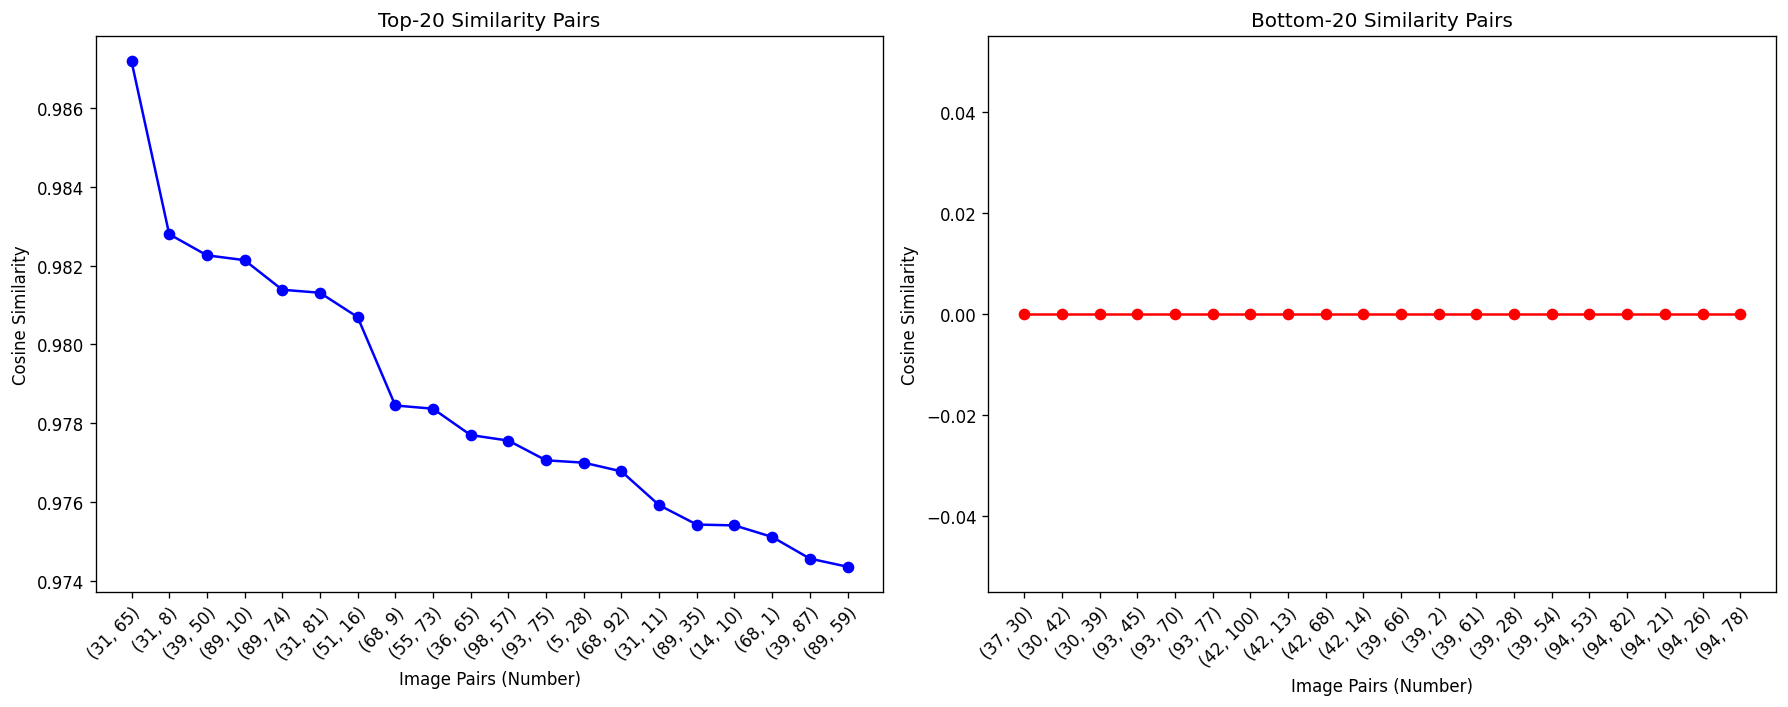

In [17]:
max_pairs_class1,min_pairs_class1=intra_category_similarity(donations_values_list1)

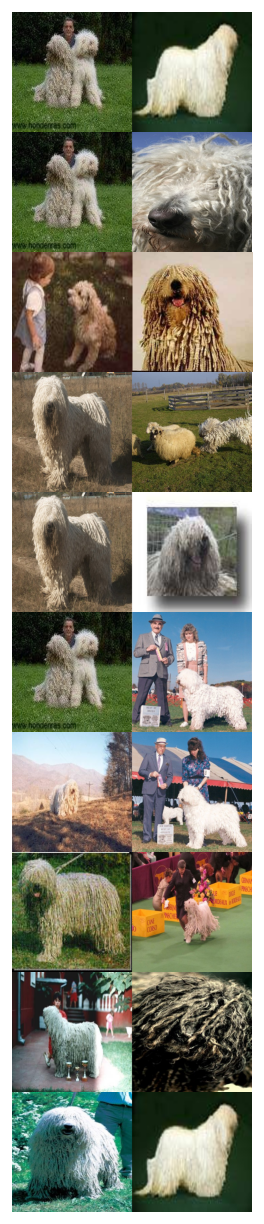

In [18]:
plot_image_pairs(max_pairs_class1, n_rows=10, figsize=(15, 10)) 

In [ ]:
plot_image_pairs(min_pairs_class1, n_rows=10, figsize=(15, 10)) 

In [ ]:
max_pairs_class2,min_pairs_class2=intra_category_similarity(donations_values_list2)

In [ ]:
plot_image_pairs(max_pairs_class2, n_rows=10,figsize=(15, 10)) 

In [ ]:
plot_image_pairs(min_pairs_class2, n_rows=10,figsize=(15, 10)) 

In [ ]:
import numpy as np  
import matplotlib.pyplot as plt  

def cross_category_similarity_optimized(donations_dict1, donations_dict2, top_n=20):  
    # 将嵌入向量转换为NumPy数组  
    img_paths1 = list(donations_dict1.keys())  
    vectors1 = np.array(list(donations_dict1.values()))  
    
    img_paths2 = list(donations_dict2.keys())  
    vectors2 = np.array(list(donations_dict2.values()))  
    
    # 计算所有图片对的点积  
    dot_products = np.dot(vectors1, vectors2.T)  
    
    # 计算模长  
    magnitudes1 = np.linalg.norm(vectors1, axis=1, keepdims=True)  
    magnitudes2 = np.linalg.norm(vectors2, axis=1)  
    
    # 计算余弦相似度  
    with np.errstate(divide='ignore', invalid='ignore'):  
        similarities = dot_products / (magnitudes1 * magnitudes2)  
    
    # 处理零向量导致的NaN  
    similarities = np.nan_to_num(similarities, 0.0)  
    
    # flatten为一维数组，并获取索引  
    similarities_flat = similarities.flatten()  
    indices = np.argsort(-similarities_flat)  
    
    max_indices = indices[:top_n]  
    min_indices = indices[-top_n:]  
    
    # 重新生成图片对信息  
    rows, cols = np.unravel_index(max_indices, similarities.shape)  
    max_similarity = []  
    for i, j in zip(rows, cols):  
        max_similarity.append({  
            'similarity': similarities[i, j],  
            'img_path1': img_paths1[i],  
            'img_path2': img_paths2[j]  
        })  
    
    rows_min, cols_min = np.unravel_index(min_indices, similarities.shape)  
    min_similarity = []  
    for i, j in zip(rows_min, cols_min):  
        min_similarity.append({  
            'similarity': similarities[i, j],  
            'img_path1': img_paths1[i],  
            'img_path2': img_paths2[j]  
        })  
    
    # 提取编号并生成标签  
    max_labels = [f"({extract_number_from_path(pair['img_path1'])}, {extract_number_from_path(pair['img_path2'])})"   
                  for pair in max_similarity]  
    min_labels = [f"({extract_number_from_path(pair['img_path1'])}, {extract_number_from_path(pair['img_path2'])})"   
                  for pair in min_similarity]  
    
    max_sim_values = [pair['similarity'] for pair in max_similarity]  
    min_sim_values = [pair['similarity'] for pair in min_similarity]  
    
    # 绘制图表  
    plt.figure(figsize=(15, 6))  
    
    # 最大相似度折线图  
    ax1 = plt.subplot(1, 2, 1)  
    ax1.plot(max_labels, max_sim_values, marker='o', color='b', label='Max Similarity')  
    ax1.set_title(f'Top-{top_n} Similarity Pairs')  
    ax1.set_xlabel('Image Pairs (Class1, Class2)')  
    ax1.set_ylabel('Cosine Similarity')  
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')  
    ax1.legend()  
  
    # 最小相似度折线图  
    ax2 = plt.subplot(1, 2, 2)  
    ax2.plot(min_labels, min_sim_values, marker='x', color='r', label='Min Similarity')  
    ax2.set_title(f'Bottom-{top_n} Similarity Pairs')  
    ax2.set_xlabel('Image Pairs (Class1, Class2)')  
    ax2.set_ylabel('Cosine Similarity')  
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')  
    ax2.legend()  

    plt.tight_layout()  
    plt.show()  
    
    # 提取图片路径对  
    max_img_pairs = [(pair['img_path1'], pair['img_path2']) for pair in max_similarity]  
    min_img_pairs = [(pair['img_path1'], pair['img_path2']) for pair in min_similarity]  
    
    # 返回相似度和图片对  
    return max_img_pairs, min_img_pairs

In [ ]:
max_img_pairs, min_img_pairs=cross_category_similarity_optimized(donations_values_list1, donations_values_list2, top_n=20)

In [ ]:
# 使用示例  
plot_image_pairs(max_img_pairs, n_rows=10,figsize=(15, 10)) 

In [ ]:
plot_image_pairs(min_img_pairs, n_rows=10,figsize=(15, 10))